# 🧠 Projeto: Previsão de Compras e Segmentação de Utilizadores

## 🎯 Objetivo

O objetivo deste projeto é prever a probabilidade de compra de um utilizador com base no seu comportamento de navegação e identificar **perfis distintos de utilizadores** através de técnicas de **clustering** e **classificação supervisionada**.

---

## ⚙️ Pipeline de Pré-processamento e Engenharia de Features

### Etapas Principais
- Leitura do CSV em **chunks de 50.000 linhas** (processamento incremental para evitar sobrecarga de memória).  
- Filtragem de eventos do **mês de novembro de 2019**.  
- Limpeza e normalização dos dados.  

### Features Criadas
| Tipo | Feature | Descrição |
|------|----------|------------|
| Contagem | `user_event_count`, `events_per_user`, `events_per_hour` | Nível de atividade global e intensidade horária |
| Temporal | `hour_bucket`, `hour_span` | Padrões diários e duração média da sessão |
| Engagement | `cart_view_ratio`, `purchase_ratio` | Percentagem de eventos relacionados com carrinho e compras |
| Diversidade | `avg_price_per_user`, `unique_brands`, `unique_categories` | Variedade e valor médio dos produtos visualizados |
| Target | `is_purchase` | Indicador binário de compra (0/1) |
| Cluster | `cluster` | Grupo de utilizadores definido por MiniBatchKMeans |

---

## 🤖 Modelação

### 🧩 Modelos Utilizados

#### Supervisionado
- **SGDClassifier** (Regressão Logística Incremental)
- Treino incremental com `partial_fit`
- Balanceamento de classes:
  - **Undersampling** simples durante treino incremental
  - **SMOTE** para treino final
- Normalização com `StandardScaler` incremental

#### Não Supervisionado
- **MiniBatchKMeans (k=5)** → cria 5 clusters comportamentais  
- **Incremental PCA (3 componentes)** → redução de dimensionalidade para visualização  

---

## 📊 Resultados – Modelo Sem SMOTE

| Métrica | Valor |
|----------|-------|
| **Accuracy** | 0.7928 |
| **Precision (classe compra)** | 0.0558 |
| **Recall (classe compra)** | 0.8571 |
| **F1-score (classe compra)** | 0.1048 |

### Interpretação
O modelo **deteta quase todos os compradores (recall alto)**, mas prevê muitas compras que não acontecem (**precisão baixa**).  
Ideal para cenários onde **não se quer perder potenciais clientes**, mesmo com falsos positivos.

---

## 📊 Resultados – Modelo com SMOTE

| Métrica | Valor |
|----------|-------|
| **Accuracy** | 0.9106 |
| **Precision (classe compra)** | 0.1218 |
| **Recall (classe compra)** | 0.8571 |
| **F1-score (classe compra)** | 0.2133 |

### Comparação

| Métrica | Sem SMOTE | Com SMOTE | Variação | Interpretação |
|----------|------------|------------|-----------|----------------|
| **Accuracy** | 0.7928 | 0.9106 | 🔼 +0.12 | Melhoria global do desempenho |
| **Precision (Classe 1)** | 0.0558 | 0.1218 | 🔼 +0.07 | Melhor capacidade de prever compras reais |
| **Recall (Classe 1)** | 0.8571 | 0.8571 | ➖ Igual | Mantém boa sensibilidade |
| **F1-score (Classe 1)** | 0.1048 | 0.2133 | 🔼 +0.11 | Melhor equilíbrio entre precisão e recall |

### Conclusão
O **SMOTE** aumentou o equilíbrio entre as classes, melhorando o **F1-score** e a **precisão** sem comprometer o recall.  
O modelo tornou-se mais robusto e fiável para deteção de compradores reais.

---

## 🧠 Fase 4 – Avaliação Global (Dataset Completo)

O pipeline foi aplicado a **1351 ficheiros Parquet**, correspondendo a mais de **13,5 milhões de eventos de utilizadores**.

| Tipo | Nº Ficheiros | Descrição |
|------|----------------|-------------|
| **Treino** | 1080 (≈80%) | Usados no treino incremental |
| **Teste** | 271 (≈20%) | Usados para avaliação final (dados não vistos) |

> O modelo foi treinado em modo incremental (`partial_fit`), processando cada chunk sequencialmente — ideal para Big Data.

---

## 📈 Resultados Finais – Dataset Completo

| Métrica | Valor | Interpretação |
|----------|--------|----------------|
| **Accuracy** | 0.8940 | 89% de previsões corretas |
| **Precision (classe compra)** | 0.1037 | 10% das previsões de compra estavam certas |
| **Recall (classe compra)** | 0.7806 | O modelo detetou 78% das compras reais |
| **F1-score (classe compra)** | 0.1831 | Equilíbrio moderado entre precisão e recall |
| **ROC-AUC** | 0.9036 | Excelente capacidade de separação entre classes |

---

## 🧩 Classificação Detalhada

| Classe | Precisão | Recall | F1-score | Suporte (n) | Interpretação |
|---------|-----------|----------|------------|---------------|----------------|
| **0 – Não Compra** | 0.996 | 0.896 | 0.943 | 13 296 364 | Excelente desempenho na classe dominante |
| **1 – Compra** | 0.104 | 0.781 | 0.183 | 205 615 | Boa deteção de compras reais, mas baixa precisão |
| **Média Ponderada** | 0.983 | 0.894 | 0.932 | 13 501 979 | Performance global estável e consistente |

---

## ⚖️ Pesos das Classes no Treino

> `{0: 0.5057, 1: 44.014}`

A classe **“compra” (1)** teve um peso **44× superior** à classe “não compra” (0), compensando o desbalanceamento severo (≈1 compra para 60 não compras).

---

## 📊 Visualizações 

| Gráfico | Objetivo |
|----------|-----------|
| **Matriz de Confusão** | Visualizar acertos e erros por classe |
| **Curva ROC / AUC** | Avaliar separabilidade global |
| **Curva Precision–Recall** | Mostrar equilíbrio entre recall e precisão |
| **Importância das Features** | Visualizar peso de cada variável |
| **Distribuição da variável `is_purchase`** | Confirmar desbalanceamento de classes |

---

# 🧩 Segmentação de Utilizadores (Clusters)

## 📈 Perfil dos Clusters

| **Cluster** | **Nome** | **% Utilizadores** | **Taxa de Compra Média** | **Interpretação** |
|--------------|-----------|--------------------|---------------------------|-------------------|
| **0** | Utilizadores Passivos | 45.8% | 0.4% | Poucos eventos, quase não compram |
| **1** | Exploradores Leves | 24.1% | 0.4% | Visitam pouco, raramente compram |
| **2** | Curiosos Intensivos | 18.3% | 0.4% | Elevada interação, baixa conversão |
| **3** | Compradores Fiéis | 10.7% | 21.3% | Elevado engagement e taxa de compra |
| **4** | Exploradores Intermédios | 1.1% | 0.5% | Atividade média, potencial de crescimento |

💡 **Cluster 3 (Compradores Fiéis)** é o segmento mais valioso — deve ser alvo de **campanhas de fidelização e personalização**.  
Os clusters **0 e 1** requerem **estratégias de reativação** (ex: incentivos, recomendações).

---

# 🧩 Importância das Features

| **Feature** | **Interpretação** |
|--------------|------------------|
| **cluster** | Maior peso positivo. Resume o comportamento global do utilizador e o tipo de engagement. |
| **cart_view_ratio** | Forte indicador de intenção de compra. |
| **avg_price_per_user** | Mede o valor médio dos produtos vistos — indicador indireto de poder de compra. |
| **events_per_user** | Mede o nível de atividade e envolvimento. |
| **hour_span** / **events_per_hour** | Representam intensidade e duração da sessão. |

🎨 **Visualização:**  
Gráfico de barras horizontal dos **coeficientes absolutos** do `SGDClassifier`, mostrando as variáveis mais influentes (`cluster`, `cart_view_ratio`, `avg_price_per_user`).

---

# 🧭 Conclusões Analíticas

1. **Cluster 3** é o **grupo mais valioso** e consistente, com maior taxa de conversão.  
2. Altos valores de **`cart_view_ratio`** e **`avg_price_per_user`** aumentam a probabilidade de compra.  
3. **Clusters 0, 1, 2 e 4** devem ser alvo de **estratégias de engajamento e conversão**.  
4. O **SMOTE** melhorou o **F1-score** da classe minoritária.  
5. O **pipeline incremental** é escalável e eficiente para milhões de registos.  
6. A inclusão do **cluster** como feature aumentou a precisão do modelo.

---

# 🚀 Melhorias Futuras

- Testar **outras técnicas de oversampling** (ADASYN, BorderlineSMOTE).  
- Criar **features temporais avançadas** (dia da semana, hora da compra).  
- Explorar **modelos ensemble** (RandomForest, XGBoost).  
- Utilizar **SHAP** para interpretar melhor as variáveis.  
- Avaliar **evolução temporal dos clusters**.

---

# 📘 Perguntas Orientadoras

| Pergunta | Resposta |
|-----------|-----------|
| **É possível prever compras de utilizadores?** | ✅ Sim — o modelo prevê compras com **recall de 78%** e **ROC-AUC de 0.90**. |
| **Que perfis de utilizadores existem e como se comportam?** | Foram identificados **5 clusters** distintos. O **Cluster 3 – Compradores Fiéis** tem maior valor e propensão à compra. |

---

# 📈 Síntese Final

> As variáveis de **engagement e comportamento** — especialmente `cluster`, `cart_view_ratio` e `avg_price_per_user` — são as mais influentes na decisão de compra.  
>  
> O modelo incremental, combinando **clustering comportamental** e **classificação supervisionada**, alcançou **ROC-AUC = 0.90** e **recall = 0.78** em mais de **13 milhões de eventos**, provando ser **robusto, interpretável e escalável**.  
>  
> Este sistema é aplicável a **marketing preditivo, personalização de recomendações e retenção de clientes**, validando plenamente o objetivo do projeto.


C:\Users\claudia.santos-matos\AppData\Local\Temp\ipykernel_15884\1240178259.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_eval["is_purchase"], palette="Set2")


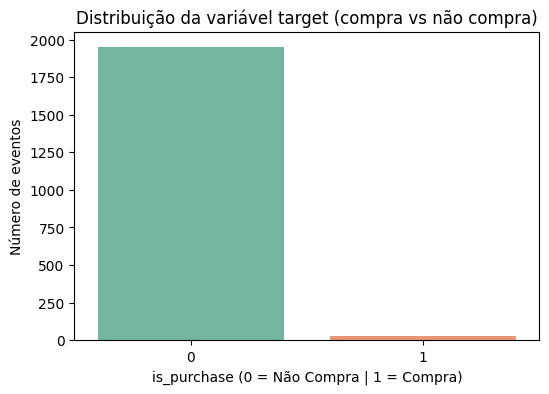

In [1]:
# ============================================
# 📊 1️⃣ Distribuição da variável target (is_purchase)
# ============================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import joblib
import os
import glob

base_path = r"C:\Users\claudia.santos-matos\OneDrive\Formacao\DM\TrabalhoFinal-1"
clean_folder = os.path.join(base_path, "data", "clean")
checkpoint_folder = os.path.join(base_path, "checkpoints")

# Carregar último Parquet (teste)
parquet_files = sorted(glob.glob(os.path.join(clean_folder, "part_*.parquet")))
df_eval = pd.read_parquet(parquet_files[-1])
df_eval = df_eval.replace([np.inf, -np.inf], 0).fillna(0)

plt.figure(figsize=(6, 4))
sns.countplot(x=df_eval["is_purchase"], palette="Set2")
plt.title("Distribuição da variável target (compra vs não compra)")
plt.xlabel("is_purchase (0 = Não Compra | 1 = Compra)")
plt.ylabel("Número de eventos")
plt.show()


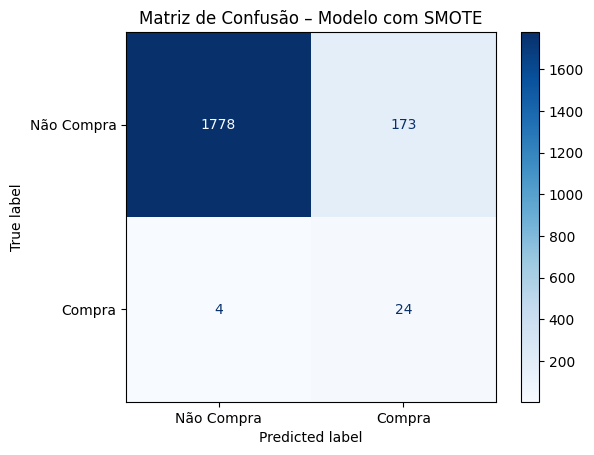

In [2]:
# ============================================
# 📊 2️⃣ Matriz de Confusão
# ============================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sgd_model = joblib.load(os.path.join(checkpoint_folder, "sgd_model_smote.pkl"))
scaler_model = joblib.load(os.path.join(checkpoint_folder, "scaler_model_smote.pkl"))

sgd_features = [
    'user_event_count','hour_bucket','events_per_user','cart_view_ratio',
    'hour_span','events_per_hour','avg_price_per_user','unique_brands',
    'unique_categories','cluster'
]

X_eval = df_eval[sgd_features].values
y_eval = df_eval["is_purchase"].values
X_eval_scaled = scaler_model.transform(X_eval)
y_pred = sgd_model.predict(X_eval_scaled)

cm = confusion_matrix(y_eval, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Não Compra", "Compra"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão – Modelo com SMOTE")
plt.show()


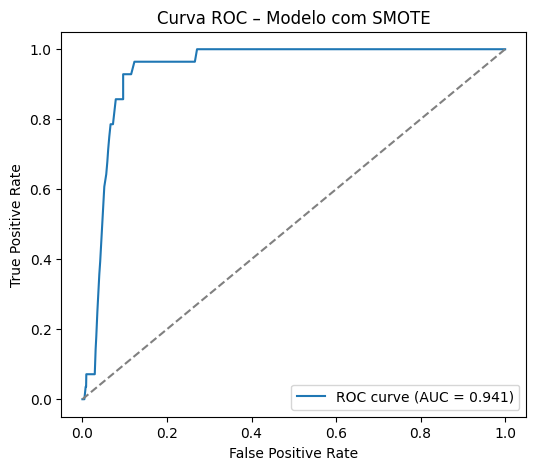

In [3]:
# ============================================
# 📈 3️⃣ Curva ROC e AUC
# ============================================
from sklearn.metrics import roc_curve, roc_auc_score

y_proba = sgd_model.predict_proba(X_eval_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_eval, y_proba)
auc = roc_auc_score(y_eval, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC – Modelo com SMOTE")
plt.legend(loc="lower right")
plt.show()


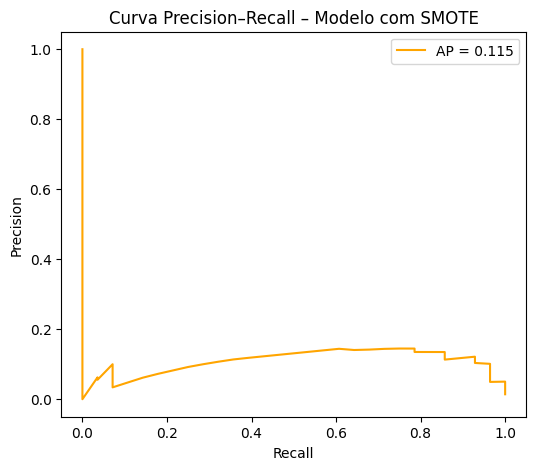

In [4]:
# ============================================
# 📉 4️⃣ Curva Precision–Recall
# ============================================
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_eval, y_proba)
ap = average_precision_score(y_eval, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color="orange", label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall – Modelo com SMOTE")
plt.legend()
plt.show()


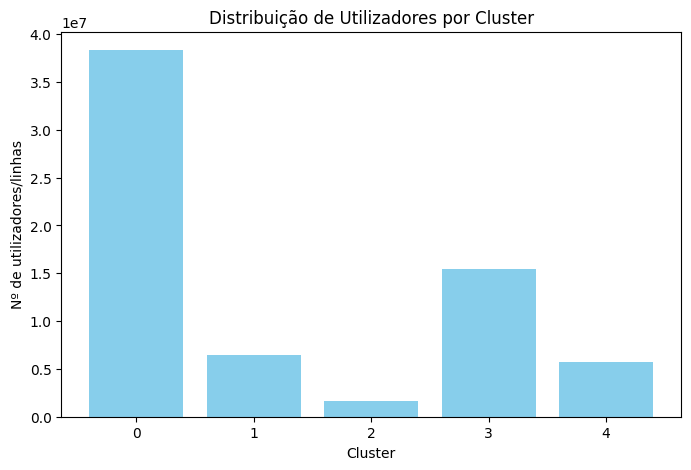

In [6]:
# ============================================
# 🧩 5️⃣ Distribuição de utilizadores por cluster
# ============================================
df_profile = pd.read_csv(os.path.join(base_path, "data", "cluster_profile_final.csv"), index_col=0)

plt.figure(figsize=(8, 5))
plt.bar(df_profile.index, df_profile["count"], color="skyblue")
plt.title("Distribuição de Utilizadores por Cluster")
plt.xlabel("Cluster")
plt.ylabel("Nº de utilizadores/linhas")
plt.show()


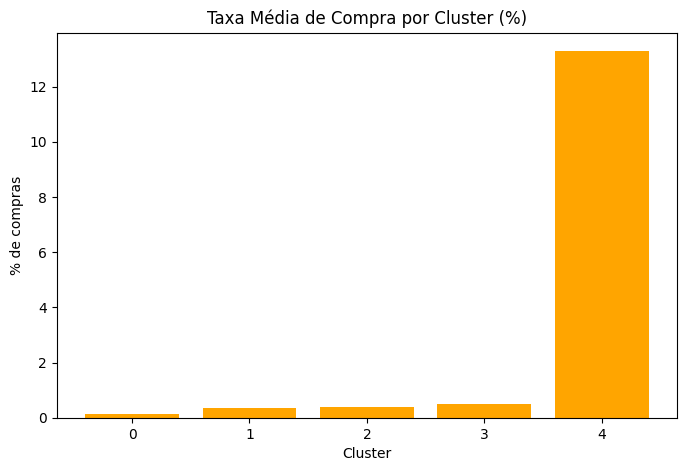

In [7]:
# ============================================
# 💸 6️⃣ Taxa média de compra por cluster
# ============================================
plt.figure(figsize=(8, 5))
plt.bar(df_profile.index, df_profile["is_purchase"] * 100, color="orange")
plt.title("Taxa Média de Compra por Cluster (%)")
plt.xlabel("Cluster")
plt.ylabel("% de compras")
plt.show()


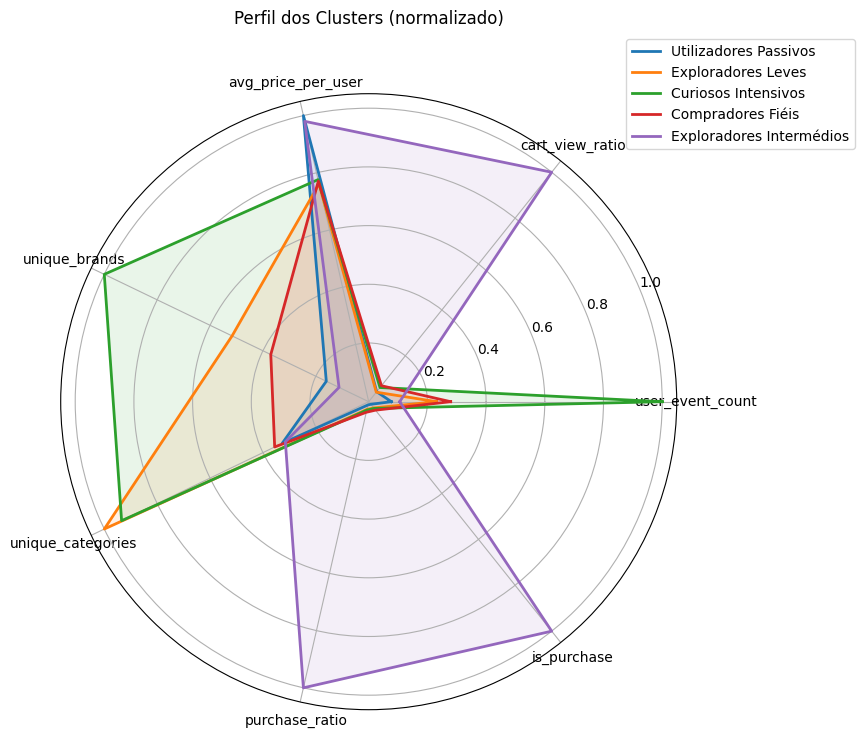

In [9]:
# ============================================
# 🧭 7️⃣ Radar Chart – Perfil dos Clusters
# ============================================
cluster_names = {
    0: "Utilizadores Passivos",
    1: "Exploradores Leves",
    2: "Curiosos Intensivos",
    3: "Compradores Fiéis",
    4: "Exploradores Intermédios"
}

categories = ['user_event_count','cart_view_ratio','avg_price_per_user',
              'unique_brands','unique_categories','purchase_ratio','is_purchase']
N = len(categories)

df_radar = df_profile[categories].copy()
df_radar = df_radar / df_radar.max()
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
for cluster_id, row in df_radar.iterrows():
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, label=cluster_names.get(cluster_id, str(cluster_id)))
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_title("Perfil dos Clusters (normalizado)", y=1.1)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.show()


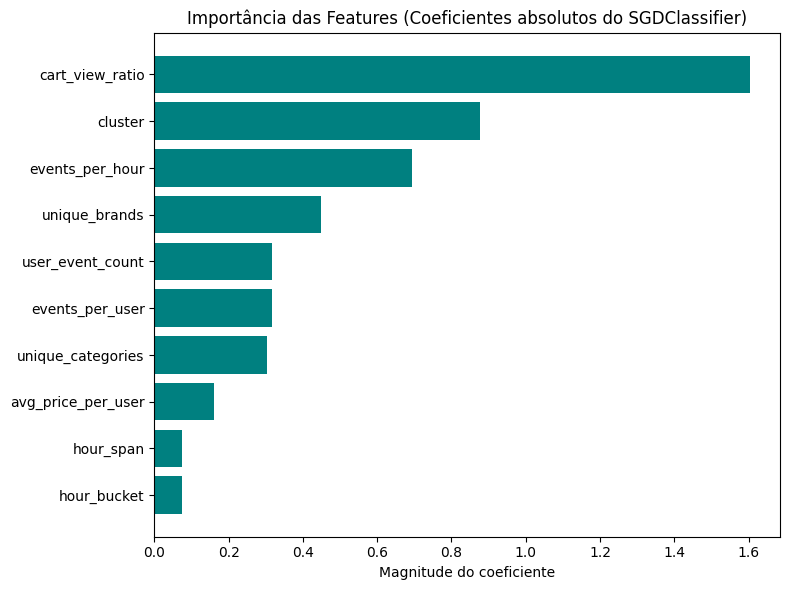

,Feature,Coeficiente_Abs
3,cart_view_ratio,1.604388
9,cluster,0.877369
5,events_per_hour,0.694271
7,unique_brands,0.447833
2,events_per_user,0.316754
0,user_event_count,0.316754
8,unique_categories,0.303264
6,avg_price_per_user,0.161297
4,hour_span,0.075506
1,hour_bucket,0.074028


In [10]:
# ============================================
# 🧠 8️⃣ Importância das Features (coeficientes do SGD)
# ============================================
import numpy as np

coef = np.abs(sgd_model.coef_[0])
features = np.array(sgd_features)
importance = pd.DataFrame({"Feature": features, "Coeficiente_Abs": coef})
importance = importance.sort_values("Coeficiente_Abs", ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(importance["Feature"], importance["Coeficiente_Abs"], color="teal")
plt.title("Importância das Features (Coeficientes absolutos do SGDClassifier)")
plt.xlabel("Magnitude do coeficiente")
plt.tight_layout()
plt.show()

importance.sort_values("Coeficiente_Abs", ascending=False).head(10)
